# Reversal by Time Horizon Strategy

The **reversal by time horizon strategy** is a trading approach that exploits the tendency of asset returns to reverse over specific time intervals. Unlike momentum strategies, which assume that past returns will continue in the same direction, reversal strategies assume that **extreme moves are temporary and will correct over time**.
- Prices can overreact in the short run due to investor sentiment, liquidity shocks or news events.  
- After a certain period, these moves tend to **reverse** as markets correct back toward fair value.  
- By systematically choosing a time horizon (e.g., intraday, daily, weekly), traders can capture profits when overextended returns revert.
   - **If past return is strongly positive** → expect reversal downward → short the asset.  
   - **If past return is strongly negative** → expect reversal upward → go long.   
#### Why It Works
- **Behavioral biases:** Traders tend to overreact to news, leading to temporary overshooting.  
- **Liquidity effects:** Forced buying/selling (e.g., during rebalancing) creates short-term mispricings.  
- **Statistical tendencies:** Negative autocorrelation at certain horizons is well-documented in financial data.  

**In summary:**  
The reversal by time horizon strategy systematically bets on the **mean-reverting nature of asset returns** at chosen intervals. By selecting and testing different horizons, traders can identify where reversals are most profitable and design robust, market-neutral strategies.

In [1]:
from time import time, sleep
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import Optional

## Data Loading and Preparation

We first load hourly price data OHLCV and clean it.

In [2]:
df = pd.read_pickle('../data/binance_1h_crypto_data.pkl')
df = df[df['open_time'].dt.date != df['open_time'].dt.date.max()]

print("Shape before {}".format(df.shape))
print("Number of duplicated rows is {}".format(df.duplicated().sum()))

df = df.drop_duplicates(keep='first')
print("Shape after {}".format(df.shape))

df.head()

Shape before (3800626, 7)
Number of duplicated rows is 0
Shape after (3800626, 7)


,open_time,open,high,low,close,volume,symbol
0,2021-01-01 00:00:00,3.18590000,3.26090000,3.04050000,3.24610000,345801.16000000,AVAXUSDT
1,2021-01-01 01:00:00,3.24920000,3.25900000,3.13710000,3.17090000,114929.77000000,AVAXUSDT
2,2021-01-01 02:00:00,3.17100000,3.17230000,3.01780000,3.08910000,296991.80000000,AVAXUSDT
3,2021-01-01 03:00:00,3.08680000,3.12360000,3.08370000,3.10850000,13442.67000000,AVAXUSDT
4,2021-01-01 04:00:00,3.11230000,3.11650000,3.08540000,3.09010000,21276.68000000,AVAXUSDT


Closing prices are used because they reflect the final consensus of value for each trading day. All assets/columns that have more than 10% null values are removed

In [3]:
def pivot_reindexed_data(df, value):
    new_df = df.pivot(values = value, columns = 'symbol', index = 'open_time')
    new_df = pd.DataFrame(new_df).astype(float)
    new_df = new_df.reindex(pd.date_range(new_df.index[0],new_df.index[-1],freq='1h'))
    return new_df

px = pivot_reindexed_data(df,'close').loc[:'2025-08']
# Omitting tickers with less than 90% of non null values.
px = px.loc[:,(px.notna().sum()/(px.shape[0]))>= 0.90]

px = px.resample('4H').last().ffill()

vols = pivot_reindexed_data(df,'volume').loc[:'2025-08']
vols = vols[px.columns]

vols = vols.resample('4H').sum().ffill()

# Define date ranges
insample_start = pd.Timestamp("2021-06-01")
insample_end = pd.Timestamp("2023-12-31")

outsample_start = pd.Timestamp("2024-01-01")

# Training set
px_train = px.loc[:insample_end]
vols_train = vols.loc[:insample_end]

In [4]:
px.tail()

symbol,1INCHUSDT,AAVEUSDT,ADAUSDT,ALGOUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,TUSDUSDT,TWTUSDT,UNIUSDT,USDCUSDT,VETUSDT,XLMUSDT,XRPUSDT,XTZUSDT,ZECUSDT
2025-08-31 04:00:00,0.2477,320.92,0.8264,0.2361,6.53,4.555,23.87,2.639,551.9,858.60,...,0.3419,0.9967,0.7427,9.817,0.9998,0.02452,0.3590,2.8289,0.7308,40.01
2025-08-31 08:00:00,0.2471,324.71,0.8243,0.2389,6.54,4.590,24.03,2.564,549.2,860.07,...,0.3428,0.9969,0.7430,9.872,0.9997,0.02468,0.3599,2.8238,0.7270,40.42
2025-08-31 12:00:00,0.2459,320.16,0.8270,0.2373,6.55,4.565,24.05,2.510,546.2,861.91,...,0.3432,0.9965,0.7482,9.804,0.9999,0.02459,0.3595,2.8222,0.7318,40.29
2025-08-31 16:00:00,0.2456,321.45,0.8216,0.2351,6.46,4.537,23.81,2.521,543.3,864.77,...,0.3424,0.9964,0.7466,9.755,0.9999,0.02443,0.3557,2.8002,0.7270,40.55
2025-08-31 20:00:00,0.2421,315.69,0.8113,0.2316,6.35,4.467,23.40,2.522,544.2,857.65,...,0.3410,0.9966,0.7368,9.619,0.9999,0.02414,0.3528,2.7757,0.7199,40.43


In [5]:
def get_top_N_coins(n=100):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    coins = []

    pages = (n // 100) + (1 if n % 100 != 0 else 0)

    for page in range(1, pages + 1):
        params = {
            "vs_currency": "usd",
            "order": "market_cap_desc",
            "per_page": 100,
            "page": page
        }
        r = requests.get(url, params=params)
        r.raise_for_status()
        coins.extend([
            (coin["id"], coin["symbol"].upper()) for coin in r.json()
        ])
        sleep(2.5)  # taking care of rate limits

    return coins[:n]  # Trimming to size n

In [6]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    return drawdown

In [7]:
def duration(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    if isinstance(returns, pd.DataFrame):
        ddd = pd.DataFrame(index = returns.index, columns = returns.columns)
        for col in returns.columns:
            ddd[col] = duration[col].groupby((duration[col] != duration[col].shift()).cumsum()).cumsum()
    else:
        ddd = duration.groupby((duration != duration.shift()).cumsum()).cumsum()
    return ddd

In [8]:
def backtest_with_costs(prices, weights, tcost_bps = 20):
    ret = prices.ffill().pct_change()
    strat_ret = (weights.shift() * ret).sum(axis=1)

    # Turnover
    turnover = (weights.fillna(0) - weights.shift().fillna(0)).abs().sum(axis=1)

    # Cost in return units
    cost = turnover * (tcost_bps * 1e-4)
    net_ret = strat_ret - cost

    return net_ret, strat_ret, turnover

In [9]:
def calculate_metrics(returns, benchmark:Optional = False):
    """
    Compute total return, annualized return/vol, Sharpe, max drawdown, win rate.
    """
    
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    max_duration = duration.groupby((duration != duration.shift()).cumsum()).cumsum().max()

    cum_ret = cumulative.iloc[-1] - 1
    ann_vol = returns.std() * np.sqrt(365 * 24 / 4)
    ann_ret = returns.mean() * 365 * 24 / 4
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = drawdown.min()

    # consider only non-zero returns as individual trades
    trade_rets = returns[returns != 0]
    win_rate   = (trade_rets > 0).sum() / len(trade_rets)
    
    metrics = pd.Series({
        "Cumulative Return": f"{(cum_ret * 100):.2f}%",
        "Annualized Return": f"{(ann_ret * 100):.2f}%",
        "Annualized Volatility": f"{(ann_vol * 100):.2f}%",
        "Sharpe Ratio": sharpe,
        "Max Drawdown": f"{(max_dd * 100):.2f}%",
        "Max Drawdown Duration": f"{(max_duration / 6):.2f} days",
        "Win Rate": f"{(win_rate * 100):.2f}%"
    })
    
    if benchmark:
        bench_rets = px['BTCUSDT'].ffill().pct_change().loc[returns.index]
        X = sm.add_constant(bench_rets)
        y = returns
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        beta  = model.params['BTCUSDT']
        active_rets = returns - beta * bench_rets
        IR = active_rets.mean() / active_rets.std() * np.sqrt(365 * 24 / 4)
    
        metrics["Info Ratio"] = IR
    else: metrics["Info Ratio"] = 'N/A'    

    return metrics

In [10]:
def volume_filter_mask(volm, lookback, pctile):
    """
    True where today's volume > rolling quantile (time-series) over the last 'lookback' days.
    Uses yesterday's threshold to avoid lookahead.
    """
    q = volm.rolling(lookback, min_periods=lookback).quantile(pctile)
    return volm > q.shift(1)

New train set is created picking coins that appear in top 100 coins by market capitalization:
This is done to ensure liquidity, reliable signals, lower transaction costs, manageable volatility, and practical execution. Due to the nature of reversal by time horizon strategy that involves frequent trading, low capitalization assets could hurt the strategy performance.

In [11]:
top_100coins  = get_top_N_coins(n=100)

top_coins = []
for i, j in top_100coins:
    top_coins.append(j+'USDT')  

px_new = px_train[px_train.columns[px_train.columns.isin(top_coins)]]
vols_new = vols_train[px_new.columns]

px_full = px[px_new.columns]

In [12]:
px_new.shape

(6565, 27)

## Trading Strategy
### Standard Rank-Demean-Normalized Portfolio Strategy
#### 1. Short-term Mean-Reversion Signal
The raw signal is the negative of the recent return over a short horizon \(H\) = 4 hours:
$$
\text{signal}_{i,t} = - \frac{1}{H} \sum_{k=0}^{H-1} resid_{i,t-k}
$$
- Negative sign: **buy recent losers, sell recent winners**.
---
#### 2. Ranking Across Assets
Signals are ranked across all assets at each time step:
$$
\text{signal}_{i,t} = \text{rank}(\text{signal}_{i,t} \text{ across all assets } i)
$$
- Ranking standardizes signals and reduces the effect of outliers.

---
#### 3. Ignore Insignificant Returns
We zero out positions where the absolute return is very small:

$$
\text{signal}_{i,t} = 0 \quad \text{if } |\text{ret}_{i,t}| < 0.1
$$

- This ensures we **don’t take positions when price changes are too small**, avoiding unnecessary trades caused by market noise.  
- Helps reduce **overtrading** and improves signal quality.

#### 4. Demeaning
Subtract the cross-sectional mean at each time step for dollar-neutrality:
$$
\text{demeaned}_{i,t} = \text{signal}_{i,t} - \frac{1}{N} \sum_{j=1}^{N} \text{signal}_{j,t}
$$

- \(N\) = number of assets.

---
#### 5. Smoothing
Smooth the demeaned signal over time using Exponential Moving Average (EMA):

$$
\text{smoothed}_{i,t} = \text{EMA}(\text{demeaned}_{i,t}, \text{span}=20)
$$
- Reduces noise and avoids overreacting to short-term fluctuations.

---
#### 6. Normalization
Normalize smoothed signal to get fully-invested, dollar-neutral weights:

$$
\text{weight}_{i,t} = \frac{\text{smoothed}_{i,t}}{\sum_{j=1}^{N} |\text{smoothed}_{j,t}|}
$$
- Positive → long, Negative → short  
- Sum of absolute weights = 1

---
**Final:** dollar-neutral, fully-invested portfolio for short-term reversal trading.

## Walk Forward Validation

In [13]:
def backtest_strategy(prices, param1, param2, start_date):
    ret = prices.ffill().pct_change()
    
    btc_hodl_ret = ret['BTCUSDT']
    corr = ret.rolling(90, min_periods = 1).corr(btc_hodl_ret)
    vol_y = ret.rolling(90, min_periods = 1).std()
    vol_btc = btc_hodl_ret.rolling(90, min_periods = 1).std()
    beta = (corr*vol_y).divide(vol_btc, axis = 0)
    resid = ret - beta.multiply(btc_hodl_ret, axis = 0)
    
    hor = 1
    signal = (-1.0*resid.rolling(hor,min_periods=1).mean())
    signal[np.abs(resid) < param1] = 0
    
    signal = signal.rank(1) # ranked
    
    signal[np.abs(resid) < param2] = 0
    signal[resid.lt(resid.quantile(0.2, axis = 1), axis = 0)] = 0
    
    port = signal.subtract(signal.mean(1),0)  #demeaned
    port = port * np.sqrt(resid.rolling(90).std())
    port = port.ewm(span=30 , min_periods=1).mean() # Smooth signal over time
    port = port.divide(port.abs().sum(1),0) # fully inversted (sum of port = 1)
    
    net_ret, gross_ret, turnover = backtest_with_costs(prices[start_date:], port[start_date:])
    
    return calculate_metrics(net_ret, True)

In [14]:
# WALK FORWARD VALIDATION SPLITS

splits = [
    ("2021-01", "2021-12", "2022-01", "2022-06"),
    ("2021-01", "2022-06", "2022-07", "2022-12"),
    ("2021-01", "2022-12", "2023-01", "2023-06"),
    ("2021-01", "2023-06", "2023-07", "2023-12")]

In [15]:
params1 = [.05, .06, .07, .08, .09, .1, .11, .12, .13, .14, .15]
params2 = [.05, .06, .07, .08, .09, .1, .11, .12, .13, .14, .15]

results = []
for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for p1 in params1:
        for p2 in params2:
            sharpe_val = backtest_strategy(px_new.loc[:val_end], 
                                    param1 = p1, 
                                    param2 = p2, 
                                    start_date = val_start)['Sharpe Ratio']
            results.append({
                "split": split_id,
                "param1": p1,
                "param2": p2,
                "val_sharpe": sharpe_val
            })
    end = time()
    print(split_id," ",end-begin, " seconds")

cv_results = pd.DataFrame(results)

# Average validation performance
avg_scores = cv_results.groupby(["param1", "param2"])["val_sharpe"].mean().reset_index()
best_params = avg_scores.loc[avg_scores["val_sharpe"].idxmax()]

print("\nAverage validation scores (top 5):")
print(avg_scores.sort_values("val_sharpe", ascending=False).head())

1   12.869574785232544  seconds
2   16.85222578048706  seconds
3   20.764830827713013  seconds
4   24.676326036453247  seconds

Average validation scores (top 5):
    param1  param2  val_sharpe
70    0.11    0.09    1.325814
59    0.10    0.09    1.263071
71    0.11    0.10    1.256596
93    0.13    0.10    1.254551
92    0.13    0.09    1.246404


In [16]:
agg = cv_results.groupby(["param1", "param2"])["val_sharpe"].agg(["mean","std"]).reset_index()

# penalize volatility
agg["robust_score"] = (agg["mean"] - agg["mean"].mean())/agg["mean"].std() \
                    - (agg["std"] - agg["std"].mean())/agg["std"].std()

agg = agg.set_index(['param1','param2'])

best_5 = avg_scores.sort_values("val_sharpe", ascending=False)[:5]\
            .set_index(['param1','param2'])

top5_score = agg.join(best_5, how = 'right').reset_index()

top5_score.sort_values(by = 'robust_score', ascending = False)

,param1,param2,mean,std,robust_score,val_sharpe
2,0.11,0.10,1.256596,0.640812,3.150727,1.256596
3,0.13,0.10,1.254551,0.787515,2.826954,1.254551
0,0.11,0.09,1.325814,1.052078,2.419486,1.325814
4,0.13,0.09,1.246404,1.095159,2.138900,1.246404
1,0.10,0.09,1.263071,1.209519,1.929490,1.263071


In [17]:
params1 = [.05, .06, .07, .08, .09, .1, .11, .12, .13, .14, .15]
params2 = [.05, .06, .07, .08, .09, .1, .11, .12, .13, .14, .15]

results = []
for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for p1 in params1:
        for p2 in params2:
            sharpe_val = backtest_strategy(px_new.loc[:val_end], 
                                    param1 = p1, 
                                    param2 = p2, 
                                    start_date = val_start)['Info Ratio']
            results.append({
                "split": split_id,
                "param1": p1,
                "param2": p2,
                "val_IR": sharpe_val
            })
    end = time()
    print(split_id," ",end-begin, " seconds")

cv_results_info = pd.DataFrame(results)

# Average validation performance
avg_scores_info = cv_results_info.groupby(["param1", "param2"])["val_IR"].mean().reset_index()
best_params = avg_scores_info.loc[avg_scores_info["val_IR"].idxmax()]

print("\nAverage validation scores (top 5):")
print(avg_scores_info.sort_values("val_IR", ascending=False).head())

1   13.044977903366089  seconds
2   17.017388105392456  seconds
3   20.80714988708496  seconds
4   25.063934326171875  seconds

Average validation scores (top 5):
     param1  param2    val_IR
70     0.11    0.09  1.162103
68     0.11    0.07  1.133156
90     0.13    0.07  1.131653
101    0.14    0.07  1.105993
59     0.10    0.09  1.103913


In [18]:
agg = cv_results_info.groupby(["param1", "param2"])["val_IR"].agg(["mean","std"]).reset_index()

# penalize volatility
agg["robust_score"] = (agg["mean"] - agg["mean"].mean())/agg["mean"].std() \
                    - (agg["std"] - agg["std"].mean())/agg["std"].std()

agg = agg.set_index(['param1','param2'])

best_5 = avg_scores_info.sort_values("val_IR", ascending=False)[:5]\
            .set_index(['param1','param2'])

top5_score = agg.join(best_5, how = 'right').reset_index()

top5_score.sort_values(by = 'robust_score', ascending = False)

,param1,param2,mean,std,robust_score,val_IR
0,0.11,0.09,1.162103,0.562536,2.486469,1.162103
4,0.10,0.09,1.103913,0.724132,1.976837,1.103913
2,0.13,0.07,1.131653,1.078512,1.222245,1.131653
3,0.14,0.07,1.105993,1.102431,1.106974,1.105993
1,0.11,0.07,1.133156,1.434482,0.402663,1.133156


Only two parameter sets appear in both highest sharpe ratio and information ratio which are [0.11, 0.09] and [0.10, 0.09], they also lead in robust score.

In [19]:
params1 = [.1, .11]
params2 = [.09]

rows = []
for p1 in params1:
    for p2 in params2:
        res = backtest_strategy(px_new, 
                                param1 = p1, 
                                param2 = p2, 
                                start_date = insample_start)
        res = pd.concat([pd.Series(p2, index = ['param2']), res])
        res = pd.concat([pd.Series(p1, index = ['param1']), res])
        rows.append(res)

output = pd.DataFrame(rows)
output = output.sort_values(["Sharpe Ratio", "Annualized Return"], ascending=False).reset_index(drop=True)
output

,param1,param2,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Duration,Win Rate,Info Ratio
0,0.11,0.09,563.41%,96.97%,69.68%,1.391790,-45.12%,407.00 days,45.70%,1.342212
1,0.10,0.09,506.87%,93.94%,70.29%,1.336514,-52.22%,436.50 days,46.05%,1.286321


### Final Selection

We select the parameter combination **(0.11, 0.09)** because it offers the best balance 
between performance and risk. While **(0.10, 0.09)** delivers slightly higher returns 
and Sharpe ratio, it also suffers from significantly deeper drawdowns (-52.22%). 

In contrast, **(0.11, 0.09)** maintains slightly higher annualized return (\~97%) 
and Sharpe ratio (\~1.39), but reduces the maximum drawdown to -45.12%. 

This makes the strategy more resilient and robust, achieving strong risk-adjusted 
performance without exposing the portfolio to unnecessarily large losses.

## Strategy Execution Training Set

The average turnover is 0.025362463338679118
The holding period is 13.142782263778855 days
                         gross_ret      net_ret     btc_hodl
Cumulative Return          782.72%      563.41%       13.21%
Annualized Return          108.08%       96.97%       21.29%
Annualized Volatility       69.76%       69.68%       57.42%
Sharpe Ratio              1.549405      1.39179     0.370779
Max Drawdown               -44.01%      -45.12%      -77.04%
Max Drawdown Duration  369.00 days  407.00 days  782.00 days
Win Rate                    45.83%       45.70%       50.73%
Info Ratio                1.504395     1.342212          N/A


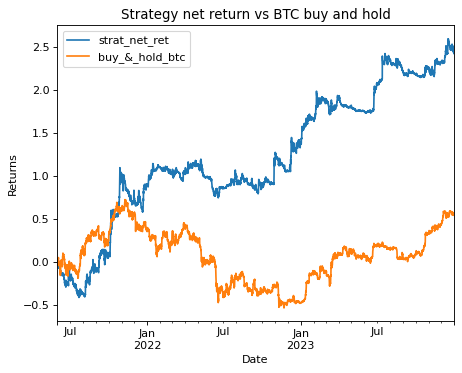

In [20]:
ret = px_new.ffill().pct_change()

btc_hodl_ret = ret['BTCUSDT']
corr = ret.rolling(90, min_periods = 1).corr(btc_hodl_ret)
vol_y = ret.rolling(90, min_periods = 1).std()
vol_btc = btc_hodl_ret.rolling(90, min_periods = 1).std()
beta = (corr*vol_y).divide(vol_btc, axis = 0)
resid = ret - beta.multiply(btc_hodl_ret, axis = 0)

hor = 1
signal = (-1.0*resid.rolling(hor,min_periods=1).mean())
signal[np.abs(resid) < 0.11] = 0

signal = signal.rank(1) # ranked

signal[np.abs(resid) < 0.09] = 0
signal[resid.lt(resid.quantile(0.2, axis = 1), axis = 0)] = 0

port = signal.subtract(signal.mean(1),0)  #demeaned

port = port * np.sqrt(resid.rolling(90).std())

port = port.ewm(span=30 , min_periods=1).mean() # Smooth signal over time

port = port.divide(port.abs().sum(1),0) # fully inversted (sum of port = 1)

net_ret, gross_ret, turnover = backtest_with_costs(px_new[insample_start:], port[insample_start:])
print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean() / 24 * 4} days")

res = pd.DataFrame({'gross_ret':calculate_metrics(gross_ret, True), 
              'net_ret':calculate_metrics(net_ret, True),
              'btc_hodl':calculate_metrics(ret['BTCUSDT'][insample_start:]),
             }) 
print(res)


relative_ret = pd.DataFrame({
    'strat_net_ret': net_ret,
    'buy_&_hold_btc': ret['BTCUSDT'][insample_start:]
})
relative_ret.cumsum().plot(title = 'Strategy net return vs BTC buy and hold',ylabel = 'Returns', xlabel = 'Date');

#### In-Sample Results
**Annualized Return** - Strategy (Net): **96.97%** vs. BTC **21.29%** → more than 3× higher growth rate.    
**Sharpe Ratio** - Strategy (Net): **1.39** vs. BTC **0.37** → far better risk-adjusted returns.   
**Max Drawdown** - Strategy (Net): **-45%** vs. BTC **-77%** → smaller worst loss.  
**Max Drawdown Duration** - Strategy (Net): **407 days** vs. BTC **782 days** → faster recovery.  
**Win Rate** - Strategy (Net): **46%** vs. BTC **51%** → wins slightly less often, but profit per win is much larger.

Overall, the in-sample test suggests the strategy is promising, but further **out-of-sample testing and robustness checks** are essential before deployment.

## Strategy Execution Test Set

The average turnover is 0.016487396629954038
The holding period is 20.217463121360147 days
                         gross_ret      net_ret     btc_hodl
Cumulative Return          357.11%      305.21%      156.00%
Annualized Return          103.87%       96.65%       68.52%
Annualized Volatility       50.87%       50.87%       49.35%
Sharpe Ratio              2.041854     1.899805     1.388496
Max Drawdown               -25.88%      -25.94%      -30.64%
Max Drawdown Duration  202.00 days  203.33 days  237.17 days
Win Rate                    46.87%       46.66%       51.67%
Info Ratio                1.792142     1.646584          N/A


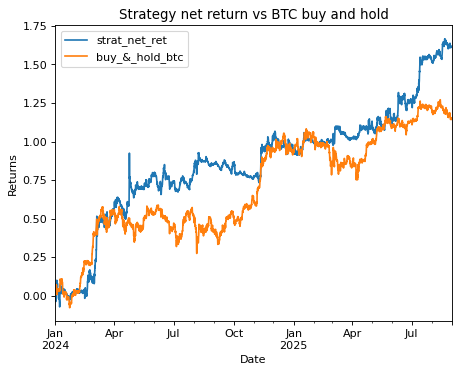

In [21]:
ret = px_full.ffill().pct_change()

btc_hodl_ret = ret['BTCUSDT']
corr = ret.rolling(90, min_periods = 1).corr(btc_hodl_ret)
vol_y = ret.rolling(90, min_periods = 1).std()
vol_btc = btc_hodl_ret.rolling(90, min_periods = 1).std()
beta = (corr*vol_y).divide(vol_btc, axis = 0)
resid = ret - beta.multiply(btc_hodl_ret, axis = 0)

hor = 1
signal = (-1.0*resid.rolling(hor,min_periods=1).mean())
signal[np.abs(resid) < 0.11] = 0

signal = signal.rank(1) # ranked

signal[np.abs(resid) < 0.09] = 0
signal[resid.lt(resid.quantile(0.2, axis = 1), axis = 0)] = 0

port = signal.subtract(signal.mean(1),0)  #demeaned

port = port * np.sqrt(resid.rolling(90).std())

port = port.ewm(span=30, min_periods=1).mean() # Smooth signal over time

port = port.divide(port.abs().sum(1),0) # fully inversted (sum of port = 1)

net_ret, gross_ret, turnover = backtest_with_costs(px_full[outsample_start:], port[outsample_start:])
print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean() / 24 * 4} days")

res = pd.DataFrame({'gross_ret':calculate_metrics(gross_ret, True), 
              'net_ret':calculate_metrics(net_ret, True),
              'btc_hodl':calculate_metrics(ret['BTCUSDT'][outsample_start:]),
             }) 
print(res)

overall = pd.DataFrame({
    'strat_net_ret': net_ret,
    'buy_&_hold_btc': ret['BTCUSDT'][outsample_start:]
})
overall.cumsum().plot(title = 'Strategy net return vs BTC buy and hold',ylabel = 'Returns', xlabel = 'Date');

In [22]:
overall.cumsum().iloc[-1]

strat_net_ret     1.612560
buy_&_hold_btc    1.143184
Name: 2025-08-31 20:00:00, dtype: float64

In [23]:
# comparing volatility-scaled returns to the benchmark
target_vol = ret['BTCUSDT'].loc[outsample_start:].std() * np.sqrt(365 * 24 / 4)
strat_vol = net_ret.std() * np.sqrt(365 * 24 / 4)
scaled_ret = net_ret * target_vol / strat_vol

scaled_ret_table = pd.DataFrame({
    'strat_net_ret': calculate_metrics(scaled_ret, True),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[outsample_start:]),
})

print(scaled_ret_table)

                      strat_net_ret     btc_hodl
Cumulative Return           290.94%      156.00%
Annualized Return            93.75%       68.52%
Annualized Volatility        49.35%       49.35%
Sharpe Ratio               1.899805     1.388496
Max Drawdown                -25.24%      -30.64%
Max Drawdown Duration   203.33 days  237.17 days
Win Rate                     46.66%       51.67%
Info Ratio                 1.646584          N/A


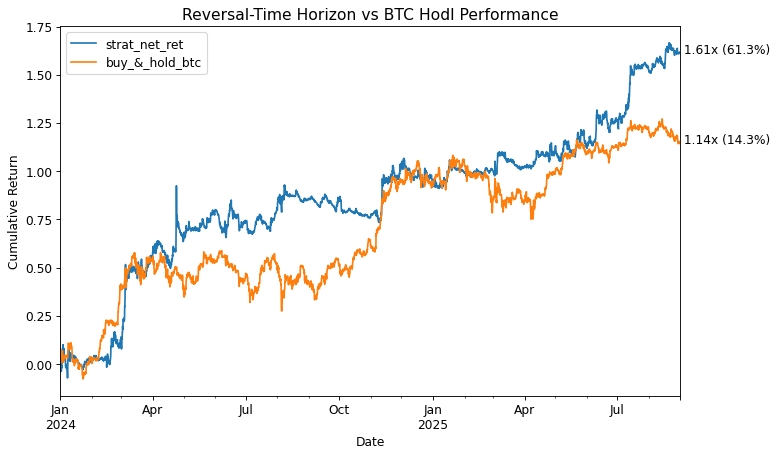

In [24]:
ax = overall.cumsum().plot(title = 'Reversal-Time Horizon vs BTC Hodl Performance',figsize = (10,6));

ax.set_title("Reversal-Time Horizon vs BTC Hodl Performance", fontsize=14)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,0], s=' 1.61x (61.3%)', 
        color="black", fontsize=11)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,1], s=' 1.14x (14.3%)', 
        color="black", fontsize=11)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

## Strategy Performance
- **Outperformance**: Strategy beats Bitcoin massively in both cumulative and annualized returns.  
- **Risk-Adjusted**: Sharpe ratio nearly **1.5x higher** than Bitcoin → better risk-adjusted performance.  
- **Drawdowns**: Strategy limits drawdowns (-26%) compared to Bitcoin’s severe -77%.  
- **Consistency**: Slightly lower win rate than Bitcoin, but profits are much larger when it wins.  

In [25]:
consistency_table = pd.DataFrame({
    'strat_ret_2024': calculate_metrics(net_ret.loc['2024']),
    'strat_ret_2025': calculate_metrics(net_ret.loc['2025']),
})

btc_table = pd.DataFrame({
    'btc_hodl_2024': calculate_metrics(ret['BTCUSDT'].loc['2024']),
    'btc_hodl_2025': calculate_metrics(ret['BTCUSDT'].loc['2025']),
})

print('Strategy Yearly Performance:')
print(consistency_table.to_string(), '\n')

print('----------------------------------------------')
print('BTC Buy and Hold Yearly Performance:')
print(btc_table.to_string())

Strategy Yearly Performance:
                      strat_ret_2024 strat_ret_2025
Cumulative Return            122.08%         82.46%
Annualized Return             94.68%         99.61%
Annualized Volatility         55.38%         43.22%
Sharpe Ratio                 1.70954       2.304873
Max Drawdown                 -25.94%        -11.43%
Max Drawdown Duration    203.33 days     47.00 days
Win Rate                      45.77%         48.01%
Info Ratio                       N/A            N/A 

----------------------------------------------
BTC Buy and Hold Yearly Performance:
                      btc_hodl_2024 btc_hodl_2025
Cumulative Return           121.31%        15.68%
Annualized Return            92.68%        32.12%
Annualized Volatility        51.86%        45.30%
Sharpe Ratio                1.78703      0.709069
Max Drawdown                -30.01%       -30.64%
Max Drawdown Duration   237.17 days   121.00 days
Win Rate                     52.37%        50.62%
Info Ratio       

In [26]:
btc_hodl_ret = ret['BTCUSDT'].loc[outsample_start:]

In [27]:
net_ret.name = 'strat_net_ret'
btc_hodl_ret.name = 'btc_hodl'
df_rets = pd.concat([net_ret, btc_hodl_ret], axis = 1)

strat_net_ret   -0.259365
btc_hodl        -0.306413
dtype: float64


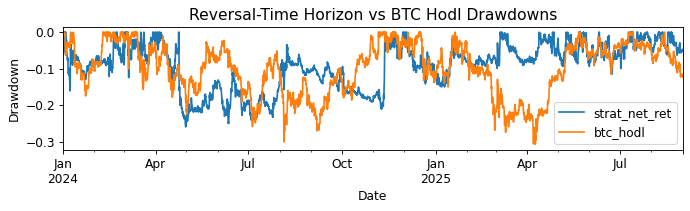

In [28]:
print(drawdown(df_rets).min())
s = drawdown(df_rets)
ax = s.plot( figsize = (10,2), title = "Reversal-Time Horizon vs BTC Hodl Drawdowns",
            xlabel = "Date", ylabel = "Drawdown");

ax.set_title("Reversal-Time Horizon vs BTC Hodl Drawdowns", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Drawdown', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

strategy maximum drawdown is -25.9%, the strategy maintained shallower drawdowns and faster recovery throughout the years

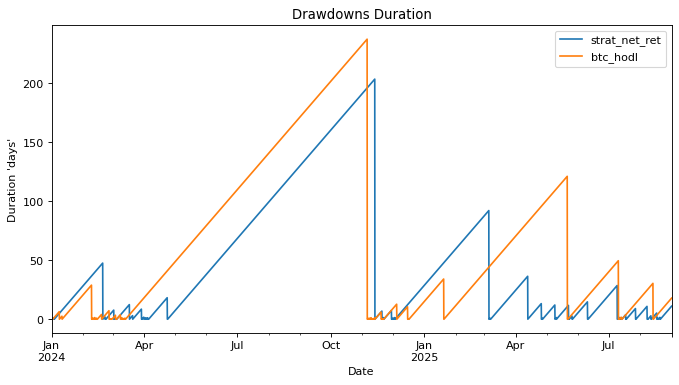

In [29]:
(duration(df_rets)/6).plot( figsize = (10,5), title = "Drawdowns Duration", 
                       xlabel = "Date", ylabel = "Duration 'days'");

In [30]:
data = pd.concat([net_ret, btc_hodl_ret], axis=1).dropna()
y = data.iloc[:,0]   # strategy
x = data.iloc[:,1]   # benchmark

# Regression (to get alpha & beta)
X = sm.add_constant(x)  
model = sm.OLS(y, X).fit()
alpha, beta = model.params
alpha_ann = alpha * 365 * 24 / 4  # annualized alpha

# Residual Returns
resid_ret = y - beta * x
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          strat_net_ret   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     165.8
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           3.83e-37
Time:                        09:34:06   Log-Likelihood:                 11419.
No. Observations:                3654   AIC:                        -2.283e+04
Df Residuals:                    3652   BIC:                        -2.282e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.126      0.0

In [31]:
print("Alpha (annualized):", alpha_ann)
print("Beta:", beta)

Alpha (annualized): 0.8192632793519068
Beta: 0.2148606583946372


- **Alpha (81.93% annualized)**: The strategy consistently generates excess returns independent of market movements.  
- **Beta (0.21)**: low BTC exposure: a 10% BTC move implies ~2% from beta, so returns are mostly alpha-driven.

In [32]:
SR = net_ret.mean() / net_ret.std() * np.sqrt(365 * 24 / 4)
IR = resid_ret.mean() / resid_ret.std() * np.sqrt(365 * 24 / 4)

print('Strategy Sharpe Ratio is ', SR)
print('Strategy Information Ratio is ', IR)

Strategy Sharpe Ratio is  1.8998049085734579
Strategy Information Ratio is  1.6465835328168308


Strategy information ratio is 1.65 which shows consistent and risk efficiency over the benchmark.

At **1.65 IR**, this strategy provides a reliable edge over BTC buy-and-hold

In [33]:
vol = {}
vol['original volatility'] = net_ret.std()*np.sqrt(365 * 24 / 4)
vol['residual volatility'] = resid_ret.std()*np.sqrt(365 * 24 / 4)
vol

{'original volatility': 0.5087243667723803,
 'residual volatility': 0.49755342685249854}

In [34]:
print('Strategy return correlation with btc hodl return is ', net_ret.corr(btc_hodl_ret))
print('Strategy residual return correlation with btc hodl return is ', resid_ret.corr(btc_hodl_ret))

Strategy return correlation with btc hodl return is  0.20841130000164887
Strategy residual return correlation with btc hodl return is  5.559521172651358e-17
